In [72]:
import pandas as pd
import numpy as np 
from tqdm.auto import tqdm
import joblib
import itertools

# 시각화
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.font_manager as fm

# 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GroupKFold, KFold, StratifiedKFold, TimeSeriesSplit
from matplotlib.dates import DateFormatter

# 모델링
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn import tree

import eli5
from eli5.sklearn import PermutationImportance
import wandb

import warnings
warnings.filterwarnings('ignore')

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

In [73]:
file_path = '/data/ephemeral/home/aistages_ml/upstage-ml-regression-07/house_price_pred/data/interim/0122_total_data.csv'
df_all = pd.read_csv(file_path)

## 1. Preprocessing

In [74]:
del df_all['동']
df_all = df_all.drop(columns=['주차대수', 'k-전체세대수', '세대수당_주차대수', '년도별_세대수당_평균_주차대수'])

df_all[['시', '구', '동']] = df_all['시군구'].str.split(' ', expand=True)

numeric_cols = df_all.select_dtypes(np.number).columns.tolist()
numeric_cols.remove('target')
categorical_cols = df_all.select_dtypes('object').columns.tolist()

df_train = df_all.query('is_test == 0')
df_test = df_all.query('is_test == 1')

# 저가 아파트 모델과 고가 아파트 모델을 분리하기 위해 실거래가가 30억 이하인 데이터만 사용
df_train = df_train.loc[(df_train['계약년월'] >= 202001) & (df_train['target'] <= 300000)]

## 2. Remove Outlier

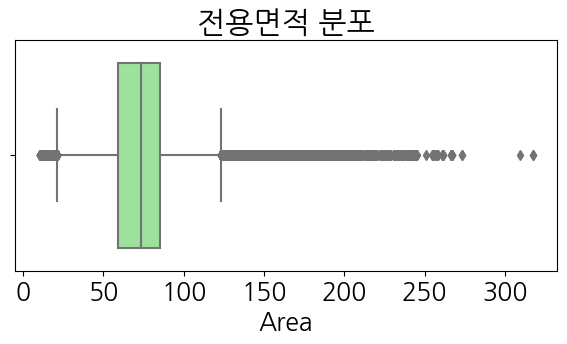

In [75]:
# 이상치 처리 
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = df_train, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [76]:
def remove_outliers_iqr(df, column_name):

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return df

df_removed_train = remove_outliers_iqr(df_train, '전용면적')
print("전용면적 이상치 처리 후 concat_data :",df_removed_train.shape) # 13968개 삭제 됨.

전용면적 이상치 처리 후 concat_data : (140000, 60)


In [77]:
df_train = df_removed_train
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

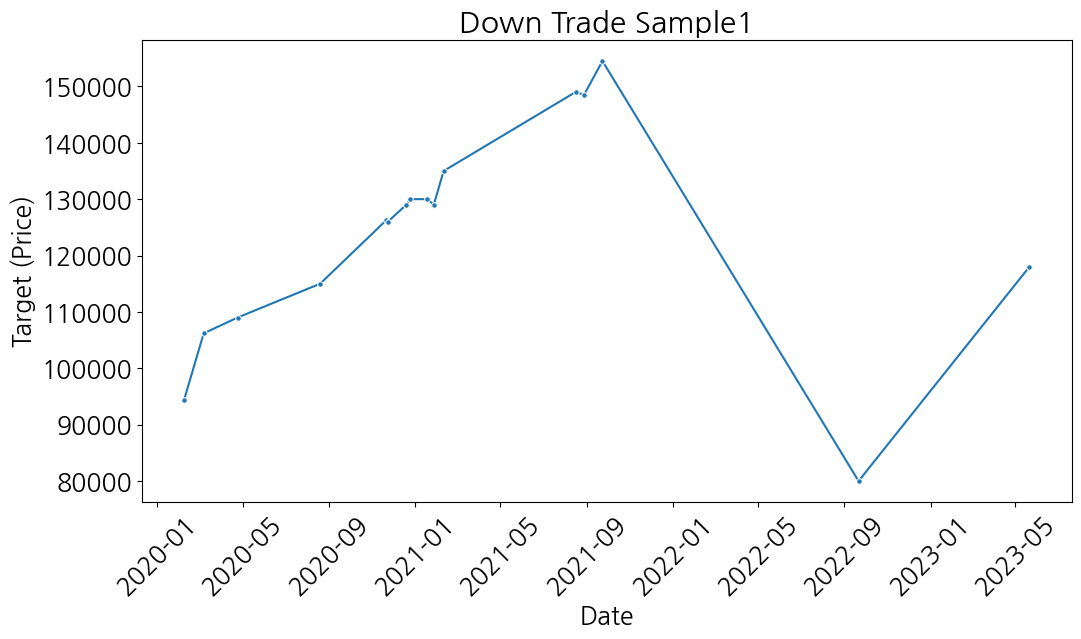

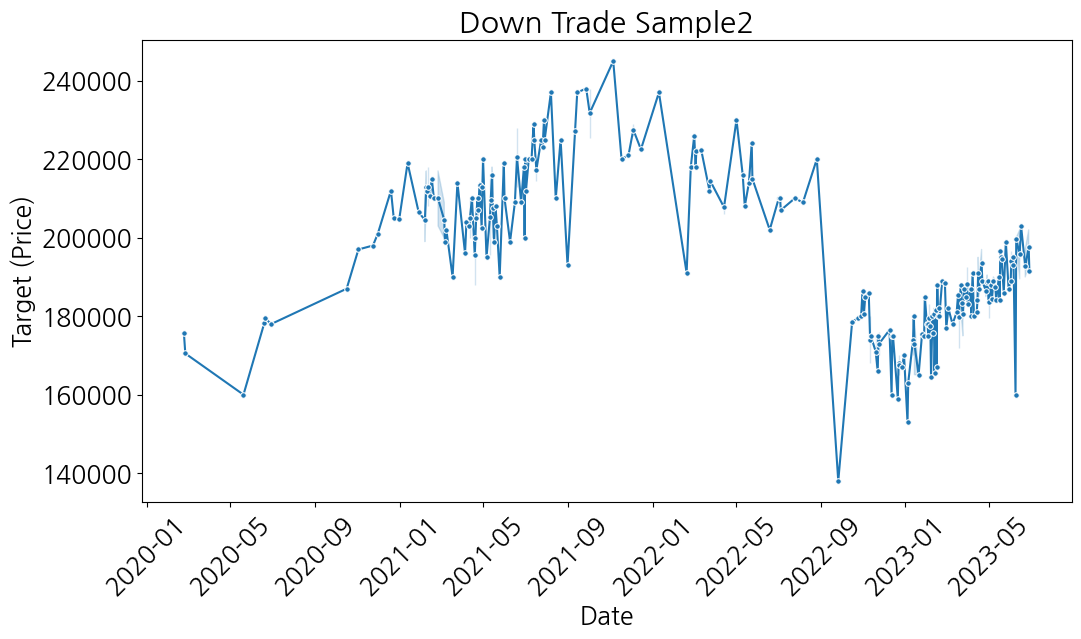

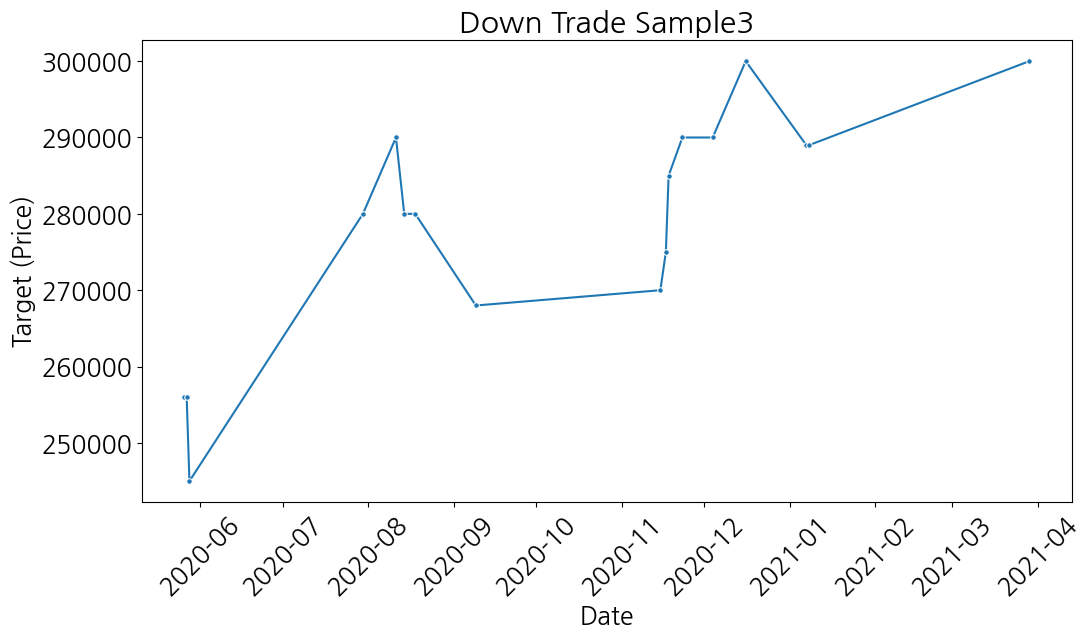

In [78]:
# 계약년월로 구성되어 있는 컬럼을 연도와 월로 나눠 컬럼을 생성합니다.
house_data = df_train.copy()
house_data["계약연도"] = house_data["계약년월"].astype(str).str[:4]  # 첫 4글자는 연도
house_data["계약월"] = house_data["계약년월"].astype(str).str[4:]  # 나머지 글자는 월

# 계약월 컬럼을 1 -> 01, 2 -> 02 형태로 포맷을 변경합니다.
house_data['계약일'] = house_data['계약일'].apply(lambda x: f'{x:02d}')

# 계약 년월일(Y-m-d) 컬럼도 함께 생성해 줍시다.
house_data["계약년월일"] = house_data["계약년월"].astype(str) + house_data["계약일"].astype(str)
house_data['계약년월일'] = pd.to_datetime(house_data['계약년월일'])

# 샘플 1
down_trade_sample1 = house_data[
    (house_data["아파트명"] == "염리삼성래미안")
    & (house_data["계약연도"] >= "2000")
    & (house_data["전용면적"] == 84.96)
]

# 샘플 2
down_trade_sample2 = house_data[
    (house_data["아파트명"] == "헬리오시티")
    & (house_data["계약연도"] >= "2000")
    & (house_data["전용면적"] >= 84)
    & (house_data["전용면적"] <= 90)
    ]

# 샘플 3
down_trade_sample3 = house_data[
    (house_data["아파트명"] == "현대14차")
    & (house_data["계약연도"] >= "2000")
    & (house_data["전용면적"] >= 84)
    & (house_data["전용면적"] <= 90)
    ]


sample_list = [down_trade_sample1, down_trade_sample2, down_trade_sample3]
# 라인 차트 생성
for idx, df in enumerate(sample_list):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='계약년월일', y='target', data=df, marker='o', markersize=4)

    plt.title(f"Down Trade Sample{idx+1}")
    plt.xlabel('Date')
    plt.ylabel('Target (Price)')

    date_formatter = DateFormatter('%Y-%m')
    plt.gca().xaxis.set_major_formatter(date_formatter)

    plt.xticks(rotation=45)

    plt.show()

In [79]:
# 삼성래미안, 헬리오시티 row 삭제
outlier_samsung = house_data.loc[(house_data['아파트명'] == '염리삼성래미안') & (house_data['target'] < 80000)].index
outlier_helio = house_data.loc[(house_data['아파트명'] == '헬리오시티') & (house_data['target'] < 140000)].index

# 이상치 값들 삭제
df_train = df_train.drop(outlier_samsung, axis=0)
df_train = df_train.drop(outlier_helio, axis=0)

### Label Encoding

In [80]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}
numeric_cols = df_train.select_dtypes(np.number).columns
categorical_cols = df_train.select_dtypes('object').columns

# Implement Label Encoding
for col in tqdm(categorical_cols):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit(df_train[col].astype(str))
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의!

    df_test[col] = lbl.transform(df_test[col].astype(str))

  0%|          | 0/11 [00:00<?, ?it/s]

## 3. Modeling

In [81]:
target_col = 'target'
input_cols = df_train.columns.tolist()
input_cols.remove(target_col)

df_train = df_train.sort_values(by='계약년월').reset_index(drop=True)
df_test = df_test.sort_values(by='계약년월').reset_index(drop=True)

In [82]:
# Train, Valid, Test dataset split
X_train = df_train.loc[df_train['계약년월'] < 202301][input_cols] # Train data로 2022년까지의 데이터 사용
Y_train = df_train.loc[df_train['계약년월'] < 202301][target_col] 

X_valid = df_train.loc[(df_train['계약년월'] >= 202301) & (df_train['계약년월'] <= 202303)][input_cols] # Valid 데이터로 2023-01 ~ 2023-03월 까지의 데이터 사용
Y_valid = df_train.loc[(df_train['계약년월'] >= 202301) & (df_train['계약년월'] <= 202303)][target_col]

X_test = df_train.loc[(df_train['계약년월'] >= 202304) & (df_train['계약년월'] <= 202306)][input_cols] # Test 데이터로 2023-04 ~ 2024-06월 까지의 데이터 사용
Y_test = df_train.loc[(df_train['계약년월'] >= 202304) & (df_train['계약년월'] <= 202306)][target_col]

display(f"Train data shape : {X_train.shape}")
display(f"Train target shape : {Y_train.shape}")

display(f"Valid data shape : {X_valid.shape}")
display(f"Valid target shape : {Y_valid.shape}")

display(f"Test data shape : {X_test.shape}")
display(f"Test target shape : {Y_test.shape}")

'Train data shape : (124098, 59)'

'Train target shape : (124098,)'

'Valid data shape : (6223, 59)'

'Valid target shape : (6223,)'

'Test data shape : (9592, 59)'

'Test target shape : (9592,)'

In [83]:
display(f"{X_train['계약년월'].min()} ~ {X_train['계약년월'].max()}")
display(f"{X_valid['계약년월'].min()} ~ {X_valid['계약년월'].max()}")
display(f"{X_test['계약년월'].min()} ~ {X_test['계약년월'].max()}")

'202001 ~ 202212'

'202301 ~ 202303'

'202304 ~ 202306'

In [84]:
# 시드고정

import os
import random

seed = 42

def random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

random_seed(seed)

### Feature Selection

#### 1. LGBM Baseline

In [85]:
gbm = lgb.LGBMRegressor(n_estimators=10000, random_state=seed)
gbm.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train),
                  (X_valid, Y_valid)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=10),
                   lgb.log_evaluation(period=10, show_stdv=True)])

model_path = '../models/no_feature_engineering_with_lgbm.pkl'
joblib.dump(gbm, model_path)

model_predict = gbm.predict(X_test)
RMSE = mean_squared_error(Y_test, model_predict)**0.5
print(f"Test rmse : {RMSE}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7755
[LightGBM] [Info] Number of data points in the train set: 124098, number of used features: 57
[LightGBM] [Info] Start training from score 85269.141275
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 20152.6	training's l2: 4.06129e+08	valid_1's rmse: 25638.9	valid_1's l2: 6.57354e+08
[20]	training's rmse: 12627.2	training's l2: 1.59447e+08	valid_1's rmse: 18501.5	valid_1's l2: 3.42304e+08
[30]	training's rmse: 10655	training's l2: 1.13528e+08	valid_1's rmse: 15481.5	valid_1's l2: 2.39676e+08
[40]	training's rmse: 9968.05	training's l2: 9.93619e+07	valid_1's rmse: 14436.7	valid_1's l2: 2.08419e+08
[50]	training's rmse: 9607.43	training's l2: 9.23028e+07	valid_1's rmse: 14012	valid_1's l2: 1.96336e+

#### 2. Filter Method

In [86]:
def get_highly_correlated_features(df, threshold=0.8):
    
    correlation_matrix = df.corr()

    # 제거 대상 변수들을 저장할 집합
    to_remove = set()

    for i in range(correlation_matrix.shape[0]):
        for j in range(i + 1, correlation_matrix.shape[1]):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                to_remove.add(correlation_matrix.columns[j])

    # 제거 대상 변수를 제외하고 남은 변수들의 리스트 변환
    selected_features = [col for col in df.columns if col not in to_remove]
    return selected_features

features1 = get_highly_correlated_features(X_train[input_cols], threshold=0.7)
display(f"Filter Method : {features1}")

"Filter Method : ['index', '복도유형', '난방방식', '전용면적', '계약일', '층', '건축년도', 'x', 'y', '아파트명', '계약년월', '도로명_x', 'mean_지상층수', 'sum_세대수', 'sum_연면적', 'sum_건축면적', 'mean_건축면적', '부속건축물수', 'bus_min_dist', 'sub_min_dist', '총인구수', '기준금리', 'dist_to_nearest_school', 'bus_count_500', 'bus_count_1000', 'bus_count_1500', 'is_station_area', '대장아파트_거리', 'is_test', '이전가격', '매매수급동향', '최저층', '거래날차이', '2016_ratio', '시', '동']"

#### 3. Feature Importances

In [87]:
def get_important_features(model, X_train, Y_train, threshold=0.8, upper=True):

    # 변수 중요도와 변수명을 함께 저장
    feature_importances = list(zip(X_train.columns, model.feature_importances_))

    # 변수 중요도를 기준으로 정렬
    sorted_features = sorted(feature_importances, key = lambda x : x[1], reverse=True if upper else False)

    # 상위 threshold(예 : 80%) 비율에 해당하는 변수의 수
    num_features_to_keep = int(threshold * len(sorted_features))

    # 상위 threshold(예 : 80%)의 변수명 선택
    selected_features = [feature[0] for feature in sorted_features[:num_features_to_keep]]

    return selected_features

In [88]:
model1 = joblib.load('/data/ephemeral/home/aistages_ml/upstage-ml-regression-07/house_price_pred/models/no_feature_engineering_with_lgbm.pkl')
features2 = get_important_features(model1, X_train, Y_train, threshold=0.7)
display(f"Feature Importance Method : {features2}")

"Feature Importance Method : ['이전가격', '전용면적', '계약년월', '건축년도', 'x', '한강거리', '대장아파트_거리', 'y', 'sum_연면적', '2016_ratio', '거래날차이', 'sum_세대수', 'mean_연면적', '층', '동', '매매수급동향', 'sum_건축면적', 'bus_count_1000', 'mean_지상층수', 'mean_건축면적', 'dist_to_nearest_school', 'bus_count_1500', 'bus_count_2000', '아파트명', '도로명_x', 'mean_높이', 'index', 'bus_count_500', '시군구', '빌딩간격', '총인구수', 'sub_min_dist', '계약일', '최고층', '도로명주소', 'bus_min_dist', '부속건축물수', '기준금리', '최저층', '2018_ratio', '도로명_split']"

#### 4. Adversarial Validation

In [89]:
adv_X_train = X_train.copy()
adv_X_valid = X_valid.copy()

adv_X_train['AV_label'] = 0
adv_X_valid['AV_label'] = 1

# 위의 두 데이터를 합치고, 셔플합니다.
adv_data = pd.concat([adv_X_train, adv_X_valid], axis=0, ignore_index=True)
adv_data_shuffled = adv_data.sample(frac=1)
adv_X = adv_data_shuffled.drop(['AV_label'], axis=1)
adv_y = adv_data_shuffled['AV_label']

In [90]:
from sklearn.ensemble import RandomForestClassifier

forest_rf = RandomForestClassifier(
    n_estimators=50,
    criterion='log_loss',
    random_state=seed,
    n_jobs=-1
)

forest_rf.fit(adv_X[input_cols], adv_y)
features3 = get_important_features(forest_rf, adv_X[input_cols], adv_y, threshold=0.7, upper=False)

display(f"Adversarial Method : {features3}")

"Adversarial Method : ['도로명_x', 'is_station_area', '대장아파트_거리', '전용면적_filtered', 'is_test', '2018_ratio', '2020_ratio', '2021_ratio', '시', '2017_ratio', 'dist_to_nearest_school', '도로명_split', '동', '복도유형', '아파트명', 'bus_count_1000', 'bus_count_500', '층', '도로명', 'bus_count_1500', '2023_ratio', '난방방식', '최저층', 'x', '전용면적', 'bus_count_2000', '시군구', 'mean_건축면적', 'y', '계약일', '구', '2022_ratio', 'mean_연면적', '한강거리', '도로명주소', '2016_ratio', '2019_ratio', 'mean_지상층수', 'index', '빌딩간격', '이전가격']"

In [91]:
def train_and_predict(X_train, Y_train, X_valid, Y_valid, X_test, features, model_name, seed=42):

    gbm = lgb.LGBMRegressor(n_estimators=10000, random_state=seed)
    gbm.fit(X_train[features], Y_train,
            eval_set=[(X_train[features], Y_train), (X_valid[features], Y_valid)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=10),
                       lgb.log_evaluation(period=10, show_stdv=True)])

    model_name = model_name
    joblib.dump(gbm, model_name)

    return gbm.predict(X_test[features])

In [92]:
all_preds = []
features = [features1, features2, features3]
model_names = ['../models/filter_selection_lgbm.pkl',
               '../models/feature_importances_lgbm.pkl',
               '../models/adversarial_validation_lgbm.pkl']

for selected_features, model_name in zip(features, model_names):
    preds = train_and_predict(
        X_train,
        Y_train,
        X_valid,
        Y_valid,
        X_test,
        selected_features,
        model_name,
        42
    )

    RMSE = mean_squared_error(Y_test, preds)**0.5
    display(f"Test rmse : {RMSE}")

    all_preds.append(preds)

# 모든 예측값의 평균을 계산
ensemble_preds = np.mean(all_preds, axis=0)

# 앙상블의 RMSE를 측정
RMSE = mean_squared_error(Y_test, ensemble_preds)**0.5
display(f"Feature Selection Ensemble Test RMSE : {RMSE}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5391
[LightGBM] [Info] Number of data points in the train set: 124098, number of used features: 34
[LightGBM] [Info] Start training from score 85269.141275
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 20215.1	valid_0's l2: 4.0865e+08	valid_1's rmse: 25802.2	valid_1's l2: 6.65752e+08
[20]	valid_0's rmse: 12697.6	valid_0's l2: 1.6123e+08	valid_1's rmse: 18511.7	valid_1's l2: 3.42682e+08
[30]	valid_0's rmse: 10781.4	valid_0's l2: 1.16238e+08	valid_1's rmse: 15873.4	valid_1's l2: 2.51966e+08
[40]	valid_0's rmse: 10086.4	valid_0's l2: 1.01736e+08	valid_1's rmse: 14845.5	valid_1's l2: 2.20388e+08
[50]	valid_0's rmse: 9727.88	valid_0's l2: 9.46317e+07	valid_1's rmse: 14415.9	valid_1's l2: 2.07818e+08
[60]	valid_0's rmse: 9453.84	valid_0's l2: 8.9375e+07	valid_1's rmse:

'Test rmse : 10938.668188060963'

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7226
[LightGBM] [Info] Number of data points in the train set: 124098, number of used features: 41
[LightGBM] [Info] Start training from score 85269.141275
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 20184.1	valid_0's l2: 4.074e+08	valid_1's rmse: 25594.8	valid_1's l2: 6.55093e+08
[20]	valid_0's rmse: 12620	valid_0's l2: 1.59265e+08	valid_1's rmse: 18309.6	valid_1's l2: 3.35242e+08
[30]	valid_0's rmse: 10675.8	valid_0's l2: 1.13972e+08	valid_1's rmse: 15607.4	valid_1's l2: 2.43592e+08
[40]	valid_0's rmse: 9994.25	valid_0's l2: 9.98851e+07	valid_1's rmse: 14868.9	valid_1's l2: 2.21086e+08
[50]	valid_0's rmse: 9633.16	valid_0's l2: 9.27978e+07	valid_1's rmse: 14415.1	valid_1's l2: 2.07794e+08
[60]	va

'Test rmse : 10791.31471372203'

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5519
[LightGBM] [Info] Number of data points in the train set: 124098, number of used features: 39
[LightGBM] [Info] Start training from score 85269.141275
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 20337.8	valid_0's l2: 4.13627e+08	valid_1's rmse: 25833.5	valid_1's l2: 6.67371e+08
[20]	valid_0's rmse: 13125	valid_0's l2: 1.72266e+08	valid_1's rmse: 20232.7	valid_1's l2: 4.09362e+08
[30]	valid_0's rmse: 11493.8	valid_0's l2: 1.32107e+08	valid_1's rmse: 18306	valid_1's l2: 3.35108e+08
[40]	valid_0's rmse: 10948.8	valid_0's l2: 1.19876e+08	valid_1's rmse: 17072.1	valid_1's l2: 2.91455e+08
[50]	valid_0's rmse: 10694.5	valid_0's l2: 1.14373e+08	valid_1's rmse: 16521.9	valid_1's l2: 2.72973e+08
[60]	valid_0's rmse: 10492.4	valid_0's l2: 1.10091e+08	valid_1's rmse: 

'Test rmse : 11896.389800431065'

'Feature Selection Ensemble Test RMSE : 10326.271110117596'